In [31]:
import gc
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from utils import seed_everything, to_var, count_parameters, show_image_grid
# from models import VAE
import torch.nn.functional as F
import time
from matplotlib import pyplot as plt
from typing import List
import numpy as np
import gzip
import base64
from PIL import Image
import io

In [32]:
# example of compressing a string
source = """The problem of searching for patterns in data is a fundamental one and has a long and successful history. For instance, the extensive astronomical observations of Tycho Brahe in the 16 century allowed Johannes Kepler to discover the empirical laws of planetary motion, which in turn provided a springboard for the development of clas- sical mechanics. Similarly, the discovery of regularities in atomic spectra played a key role in the development and verification of quantum physics in the early twenti- eth century. The field of pattern recognition is concerned with the automatic discov- ery of regularities in data through the use of computer algorithms and with the use of these regularities to take actions such as classifying the data into different categories."""
output = gzip.compress(source.encode("utf-8"))
print(len(source), "=>", len(output), "\t", "ratio:", len(output) / len(source))

768 => 436 	 ratio: 0.5677083333333334


In [33]:
gc.collect()
seed_everything(42)
# CONST TABLE
MPS_FLAG = torch.backends.mps.is_available()
BATCH_SIZE = 1
NUM_SAMPLES = 10
K = 5
NUM_TEST = 200


In [34]:
gc.collect()
if MPS_FLAG:
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Backend device: {}".format(device))
data_path = "../datasets/"
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)
dataset1 = datasets.MNIST(data_path, train=True, download=True, transform=transform)
dataset2 = datasets.MNIST(data_path, train=False, transform=transform)

Backend device: mps


In [35]:
gc.collect()

indices = [[] for _ in range(10)]
for idx, (_, label) in enumerate(dataset1):
    indices[label].append(idx)

sampled_indices = []
for label_indices in indices:
    sampled_indices.extend(np.random.choice(label_indices, NUM_SAMPLES, replace=False))

sampled_dataset = Subset(dataset1, sampled_indices)
# sampled_loader = DataLoader(sampled_dataset, batch_size=64, shuffle=True)
print("Number of samples:", len(sampled_dataset))

Number of samples: 100


Accuracy: 0.005
Average length of each digit: [0.82953262 0.73049407 0.87710194 0.90938065 0.83748328 0.94262816
 0.85971517 0.90440214 0.85304969 0.86467326]


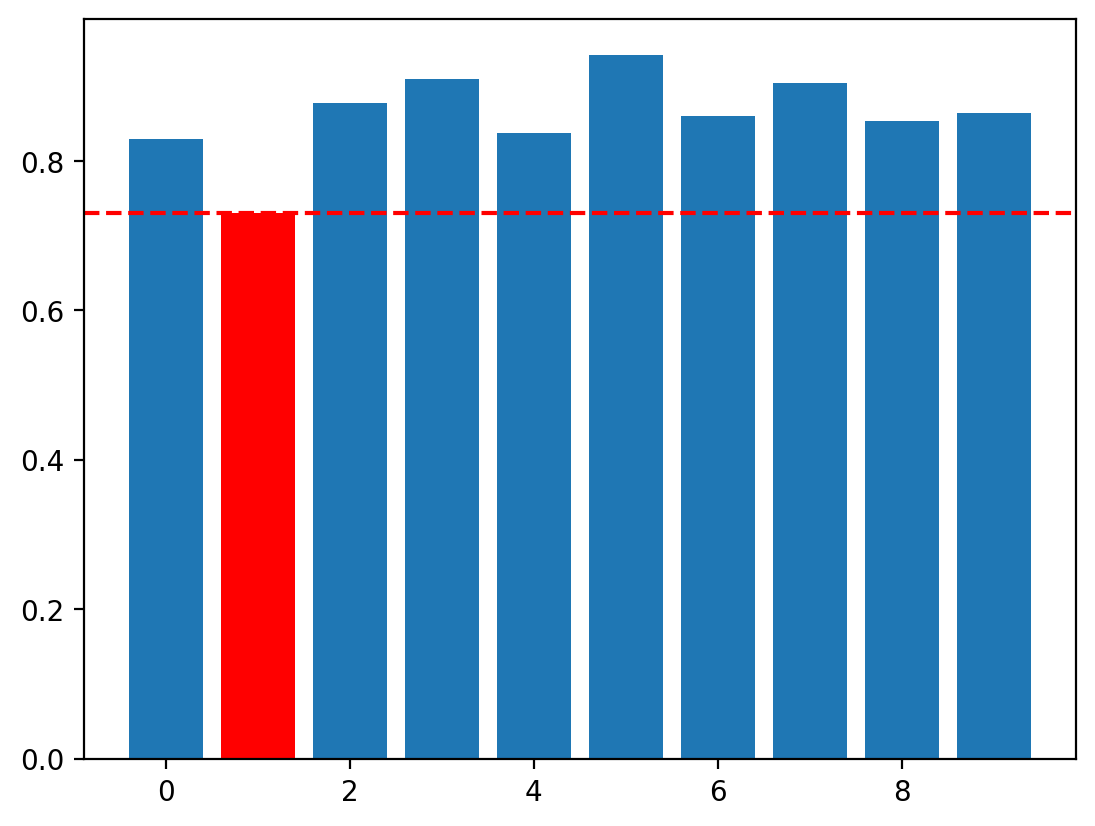

In [36]:
gc.collect()


def f_compress(image: torch.Tensor) -> List[int]:
    # image = torch.round(image)  # round(image)
    image = image > 0.5
    image_flat = image.flatten().numpy().astype(np.uint8)
    # print(image_flat.dtype)
    image_string = "".join(image_flat.astype(str))
    # print(image_string)
    # image_string = "".join([str(int(i)) for i in image_flat])
    # chunks = [image_string[i : i + 8] for i in range(0, len(image_string), 8)]
    # image_bytes = bytes([int(chunk, 2) for chunk in chunks])
    image_compressed = gzip.compress(image_string.encode())
    return [len(image_compressed), image_compressed, image_string]


def f_compress_mutual(image: torch.Tensor) -> List[int]:
    # print(image.shape)
    fc_1, compress_str_1, image_bytes_1 = f_compress(image[:, :, 0])
    fc_2, compress_str_2, image_bytes_2 = f_compress(image[:, :, 1])
    image_string_joint = " ".join([image_bytes_1.decode(), image_bytes_2.decode()])
    image_compressed = gzip.compress(image_string_joint.encode())
    return [len(image_compressed), image_compressed]


SEL_LABEL = 1
seed_everything(42)

correct_percentage = 0
cnt = 0
ave_distance = np.zeros(10)
triggered = False
for test_image, test_label in dataset2:
    if test_label != SEL_LABEL:
        continue
    else:
        triggered = True
    # print(test_image.squeeze().shape, test_label)
    fc_1, _, __ = f_compress(test_image.squeeze())
    # print(fc_1,len(__))
    # break
    # print(fc_1)
    distance_from_1 = []
    for train_image, train_label in sampled_dataset:
        fc_2, _, __ = f_compress(train_image.squeeze())
        # 0.72
        # image_agg = torch.stack([test_image.squeeze(), train_image.squeeze()], -1)
        # 0.74
        image_agg = torch.stack([train_image.squeeze(), test_image.squeeze()], -1)
        fc_3, _, __ = f_compress(image_agg)
        # fc_3,_ = f_compress_mutual(image_agg)
        # print(fc_1, fc_2, fc_3)
        NCD = (fc_3 - min(fc_1, fc_2)) / max(fc_1, fc_2)
        distance_from_1.append(NCD)
        ave_distance[train_label] += NCD
    sorted_idx = np.argsort(np.array(distance_from_1))
    top_k_class = [sampled_dataset[i][1] for i in sorted_idx[:K]]
    # sampled_dataset[sorted_idx[:K],1]
    predict_class = max(set(top_k_class), key=top_k_class.count)
    if predict_class == test_label:
        correct_percentage += 1
    cnt += 1
    print(cnt, correct_percentage / cnt, end="\r")
    if cnt == NUM_TEST:
        break
    if triggered:
        break
print("Accuracy:", correct_percentage / NUM_TEST)
# 0.72
plt.figure(dpi=200)
ave_distance_ = ave_distance / NUM_SAMPLES
print("Average length of each digit:", ave_distance_)
plt.bar(np.arange(10), ave_distance_)
# mark the selected bar red
plt.bar(SEL_LABEL, ave_distance_[SEL_LABEL], color="red")
# draw a line at the selected top
plt.axhline(ave_distance_[SEL_LABEL], color="red", linestyle="--")